In [2]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

In [3]:
class SynthDataset(Dataset):
    def __init__(self, num_examples=1000, range_list=(-1, 1), num_features=2):
        self.num_examples = num_examples
        self.range_list = range_list
        self.num_classes = num_features
        self.range_max = range_list[1]
        self.range_min = range_list[0]

        self.X = (self.range_max - self.range_min) * torch.rand(num_examples, num_features) + self.range_min
        self.y = (self.X[:, 0]**2 + self.X[:, 1]**2 < 0.6).float()

    def __len__(self):
        return self.num_examples

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [4]:
class Multi_Layer_Perceptrone(nn.Module):
    def __init__(self, num_features, num_classes, activation="tanh", hidden_size=[128, 64, 32], use_batchnorm=False, dropout_rate=0.0):
        super(Multi_Layer_Perceptrone, self).__init__()
        self.num_features = num_features
        self.num_classes = num_classes
        self.size = [self.num_features] + hidden_size + [self.num_classes]
        self.use_batchnorm = use_batchnorm
        self.dropout_rate = dropout_rate

        if activation == "tanh":
            self.activation = nn.Tanh()
        elif activation == "relu":
            self.activation = nn.LeakyReLU()
        elif activation == "sigmoid":
            self.activation = nn.Sigmoid()

        layers = nn.ModuleList()
        for i in range(len(self.size) - 1):
            layers.append(nn.Linear(self.size[i], self.size[i+1]))

            if use_batchnorm and i < len(self.size) - 2:
                layers.append(nn.BatchNorm1d(self.size[i+1]))

            if i < len(self.size) - 2:
                layers.append(self.activation)

            if dropout_rate > 0 and i < len(self.size) - 2:
                layers.append(nn.Dropout(self.dropout_rate))

        self.model = nn.Sequential(*layers)


    def forward(self, x):
        return self.model(x)

Using device: cpu
(array([0., 1.], dtype=float32), array([514, 486]))


  4%|▍         | 2/50 [00:00<00:02, 17.38it/s]

Epoch 0
Train Loss: 0.7019
Val Loss: 0.6969
Val Accuracy: 0.5360



 28%|██▊       | 14/50 [00:00<00:01, 21.81it/s]

Epoch 10
Train Loss: 0.2856
Val Loss: 0.2394
Val Accuracy: 0.9520



 48%|████▊     | 24/50 [00:00<00:00, 26.98it/s]

Epoch 20
Train Loss: 0.0875
Val Loss: 0.0747
Val Accuracy: 0.9840



 72%|███████▏  | 36/50 [00:01<00:00, 29.68it/s]

Epoch 30
Train Loss: 0.0787
Val Loss: 0.0465
Val Accuracy: 0.9920



 92%|█████████▏| 46/50 [00:01<00:00, 30.08it/s]

Epoch 40
Train Loss: 0.0524
Val Loss: 0.0443
Val Accuracy: 0.9840



100%|██████████| 50/50 [00:01<00:00, 26.96it/s]


Final Validation Results:
Accuracy: 0.9960
Max accuracy: 1.0000, on 17 epochs

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       138
         1.0       0.99      1.00      1.00       112

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



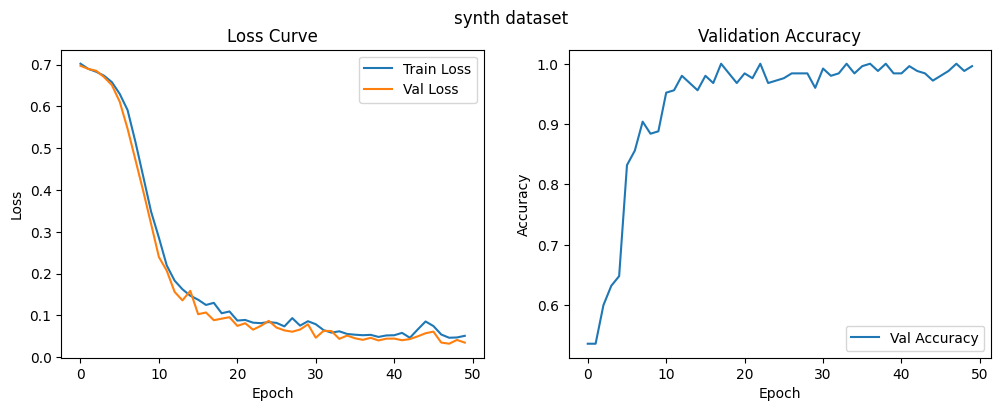

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dataset = SynthDataset(num_examples=1000, range_list=(-1, 1), num_features=2)

print(np.unique(dataset.y, return_counts=True))
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

model = Multi_Layer_Perceptrone(2, 2, activation="tanh").to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_acc = 0
train_losses = []
val_losses = []
val_accuracies = []

for epoch in tqdm(range(50)):
    model.train()
    epoch_train_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        y_pred = model(x)
        loss = criterion(y_pred, y.long())

        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))

    model.eval()
    epoch_val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)

            y_pred = model(x)
            loss = criterion(y_pred, y.long())
            epoch_val_loss += loss.item()

            preds = torch.argmax(y_pred, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    val_losses.append(epoch_val_loss / len(val_loader))
    val_acc = accuracy_score(all_labels, all_preds)
    val_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}")
        print(f"Train Loss: {train_losses[-1]:.4f}")
        print(f"Val Loss: {val_losses[-1]:.4f}")
        print(f"Val Accuracy: {val_acc:.4f}\n")

model.eval()

all_preds = []
all_labels = []
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        preds = torch.argmax(y_pred, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

print("Final Validation Results:")
print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
print(f"Max accuracy: {np.max(val_accuracies):.4f}, on {np.argmax(val_accuracies)} epochs")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.suptitle("synth dataset")
plt.show()